In [1]:
# import all necessary libraries
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from preprocess import *

import dataset as ds
import utils
import transformer_timeseries as tst

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # forcing to work on the cpu to not run out of memory

In [3]:
# loads dataset, only looking at the first 2000 entries (to speed up runtime down the road)
data = load_dataset('dataset_wav_10000.pkl')
data=data[:2000]
data = torch.FloatTensor(data).resize(2000, 1, 16000)

# initializes dataset and takes a batch_size of 1 for generating 1 sample at a time
clip_dataset = torch.utils.data.TensorDataset(data, data)
batch_size=1
train_loader = torch.utils.data.DataLoader(
    clip_dataset,
    batch_size = batch_size,
    shuffle=True
)

(10000, 16000)


c:\Users\Astro\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [4]:
## Params [many unused], mostly from training notebook and only a few used for generation
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
dec_seq_len = 160 # length of input given to decoder
enc_seq_len = 160 # length of input given to encoder
output_sequence_length = 160 # target sequence length. If hourly data and length = 48, you predict 2 days ahead
window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
step_size = 1 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048
max_seq_len = enc_seq_len
batch_first = False

# initializes model and loads in pre-trained, saved model!
loaded_model = tst.TimeSeriesTransformer(
    input_size=1,
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features=1
).to(device)
loaded_model.load_state_dict(torch.load('./test_model_40_20.pt', map_location=device))

<All keys matched successfully>

In [5]:
for i, batch in enumerate(train_loader):
        # prep batch stuff manually
        # i: index of batch
        # batch[0] contains the data
        batch = batch[0]
        # print(i)

        if batch_first:
            batch = batch.permute(0, 2, 1) # batch_size * 16000 * 1

            src = batch[:,:enc_seq_len,:]
            trg = batch[:,enc_seq_len-1:15999,:] # wrong; fix later
            trg_y = batch[:,-output_sequence_length:,:] # wrong; fix later

        else:
            batch = batch.permute(2, 0, 1) # 16000 * 50 * 1

            # shift, so that we extract our sample from the middle of the clip
            t = 8000

            # extract data (ran out of memory when trying to use full 16000 data)
            src_original = batch[:,:,:]
            src = batch[t:(enc_seq_len+t),:,:].to(device)
            tgt = batch[(enc_seq_len-1+t):(enc_seq_len+dec_seq_len-1+t),:,:].to(device)
            tgt[140:,:,:] = torch.zeros(20, batch_size, 1)
            tgt_y = batch[(enc_seq_len+t):(enc_seq_len+output_sequence_length+t),:,:].to(device)

In [6]:
# initializes full signal data tensor and adds first 300 samples from source
full_signal = src
full_signal = torch.cat((full_signal, tgt[:140,:,:]))

In [7]:
# generation loop to produce 2 seconds of audio
while full_signal.shape[0] < 16000:
    # we were having some memory problems so we added this to clear some memory
    torch.cuda.empty_cache()

    # produces model output and clamps values to be bound by [-1.0, 1.0]
    output = torch.clamp(loaded_model(src=src, tgt=tgt), min=-1., max=1.)
    output_numpy = output.detach().numpy()

    # calculates "unmasked" values and adds to the end of our wav data
    original_max = max(max(tgt[:140].detach().numpy()), max(-1.0 * tgt[:140].detach().numpy()))
    constructed_max = max(max(output_numpy[140:]), max(-1.0 * output_numpy[140:]))
    scaled_output = output[140:].detach() / float(constructed_max) * float(original_max)
    print(full_signal.shape, original_max, constructed_max)
    full_signal = torch.cat((full_signal, scaled_output), 0)

    # clears out some memory :)
    del output_numpy
    del scaled_output
    del output
    del src
    del tgt

    # reconstructs source and target from our built wav data
    src = full_signal[-300:-140,:,:]
    ## target construction using noise (required to be small or we see all values blow up)
    # tgt = torch.cat((full_signal[-140:,:,:], torch.normal(mean=torch.zeros(20,batch_size,1), std=torch.zeros(20,batch_size,1)+0.01)),0)
    ## target construction using zeros instead of noise
    tgt = torch.cat((full_signal[-140:,:,:], torch.zeros(20,batch_size,1)),0)

torch.Size([300, 1, 1]) [[0.18423408]] [[0.03824863]]
torch.Size([320, 1, 1]) [[0.18423408]] [[0.02844059]]
torch.Size([340, 1, 1]) [[0.18423408]] [[0.02697903]]
torch.Size([360, 1, 1]) [[0.18423408]] [[0.02698197]]
torch.Size([380, 1, 1]) [[0.18423408]] [[0.02158158]]
torch.Size([400, 1, 1]) [[0.18423408]] [[0.02190772]]
torch.Size([420, 1, 1]) [[0.18423408]] [[0.02691767]]
torch.Size([440, 1, 1]) [[0.18423408]] [[0.02097357]]
torch.Size([460, 1, 1]) [[0.18423408]] [[0.03238664]]
torch.Size([480, 1, 1]) [[0.18423408]] [[0.03019308]]
torch.Size([500, 1, 1]) [[0.18423408]] [[0.02720308]]
torch.Size([520, 1, 1]) [[0.18423408]] [[0.0224048]]
torch.Size([540, 1, 1]) [[0.18423408]] [[0.01762882]]
torch.Size([560, 1, 1]) [[0.18423408]] [[0.02836559]]
torch.Size([580, 1, 1]) [[0.18423408]] [[0.02412111]]
torch.Size([600, 1, 1]) [[0.18423408]] [[0.01974841]]
torch.Size([620, 1, 1]) [[0.18423408]] [[0.02464037]]
torch.Size([640, 1, 1]) [[0.18423408]] [[0.02506843]]
torch.Size([660, 1, 1]) [[0.1

In [8]:
# builds numpy array from the output signal tensor
output_signal = np.array(full_signal.squeeze().detach())

In [9]:
# saves generated, original, and merged data to .wav files
trial_number = 10
src_data = torch.squeeze(src_original).detach().numpy()
merged_data = (src_data[:16000] + output_signal) / 2
produce_wav(wav_data=output_signal, file_name='./merging/' + str(trial_number) + '_Generated.wav')
produce_wav(wav_data=src_data, file_name='./merging/' + str(trial_number) + '_Original.wav')
produce_wav(wav_data=merged_data, file_name='./merging/' + str(trial_number) + '_Merged.wav')

In [10]:
# a short attempt to look using a fourier analysis to find the dominant frequency 
import scipy.fftpack as fftpack
fourier = fftpack.fft(full_signal.detach().numpy())
normalized_fourier = np.squeeze(np.abs(fourier))
freq_dist = fftpack.fftfreq(300, d=1.0/8000.)
print("DOMINANT FREQUENCY: " + str(freq_dist[np.argmax(normalized_fourier)]))
highest_freq = freq_dist[np.argmax(normalized_fourier)]

DOMINANT FREQUENCY: -1226.6666666666667


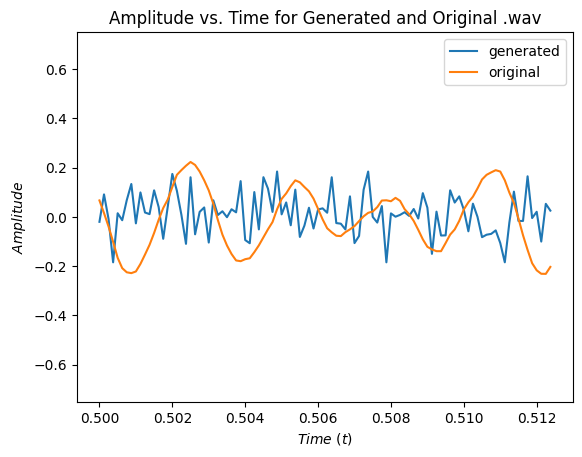

In [24]:
# plots 100 samples in the middle of the generated and original data
# also plots dominant frequency over the graph if line 14 is uncommented
n = 100
t = np.arange(0, 2, 1/8000.)
s = np.sin(t * highest_freq * 2 * np.pi) * 0.8
plt.clf()
plt.plot(t[4000:4000+n], output_signal[4000:4000+n], label='generated')
plt.plot(t[4000:4000+n], torch.squeeze(src_original).detach().numpy()[4000:4000+n], label='original')
plt.ylim((-0.75, 0.75))
plt.xlabel(r'$Time\ (t)$')
plt.ylabel(r'$Amplitude$')
plt.title(r'Amplitude vs. Time for Generated and Original .wav')
plt.legend()
# plt.plot(t[4000:4000+n], s[4000:4000+n], alpha=0.3)
plt.show()